# Packages and libraries

In [67]:
!pip install torch numpy matplotlib pandas scikit-learn

  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [17 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\pickle5
  copying pickle5\pickle.py -> build\lib.win-amd64-cpython-312\pickle5
  copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-312\pickle5
  copying pickle5\__init__.py -> build\lib.win-amd64-cpython-312\pickle5
  creating build\lib.win-amd64-cpython-312\pickle5\test
  copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-312\pickle5\test
  copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-312\pickle5\test
  copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-312\pickle5\test
  copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-312\pickle5\test
  running build_ext
  building 'pickle5._pickle' extension
  error: Mi

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

import pickle

# Reading Training Data

In [71]:
data_folder = 'Data'
filename = 'Clean_data.csv'
file_path = os.path.join(data_folder, filename)

if not os.path.isfile(file_path):
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")

# Read the CSV without parsing dates
merged_df = pd.read_csv(file_path)

In [73]:
# Define Variables
merged_df['Lag_y1'] = merged_df['Output_gap (%)'].shift(1)
merged_df['Lag_y2'] = merged_df['Output_gap (%)'].shift(2)
merged_df['Lag_pi1'] = merged_df['Inflation_Rate (%)'].shift(1)
merged_df['Lag_pi2'] = merged_df['Inflation_Rate (%)'].shift(2)
merged_df['Lag_i1'] = merged_df['Avg_Interest_Rate'].shift(1)
merged_df['Lag_i2'] = merged_df['Avg_Interest_Rate'].shift(2)

# Drop rows with NaN values created due to lagging
merged_df = merged_df.dropna()

print(merged_df)

   Quarter  Avg_Interest_Rate  GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%)  \
2   1988Q1              8.630         133283        137215            2.95   
3   1988Q2              8.080         136630        141576            3.62   
4   1988Q3             10.755         140801        145602            3.41   
5   1988Q4             12.880         144969        149469            3.10   
6   1989Q1             12.880         148623        152205            2.41   
..     ...                ...            ...           ...             ...   
75  2006Q2              4.500         367042        366712           -0.09   
76  2006Q3              4.750         370883        370824           -0.02   
77  2006Q4              5.000         372900        372629           -0.07   
78  2007Q1              5.250         376958        378202            0.33   
79  2007Q2              5.500         386144        387920            0.46   

    GDP Deflator  Inflation_Rate (%)  Lag_y1  Lag_y2  Lag_pi1  

# 1. Simple ANN block

In [75]:
class ANN(nn.Module):
    """A simple feedforward ANN with 1 hidden layer."""
    def __init__(self, input_dim, hidden_dim):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

# 2. ANN Model Class

In [77]:


class ANN_Model:
    """
    Model for predicting the output gap, using an ANN internally.
    It includes StandardScalers for X (features) and y (target),
    so that predict() can handle unscaled data automatically.
    """
    def __init__(self, input_dim, hidden_dim=3, lr=0.01):
        self.model = ANN(input_dim, hidden_dim)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Scalers for features and target
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        self.train_losses = []
        self.val_losses = []
        self.fitted = False

    def fit(self, X_train, y_train, X_val, y_val, 
            max_epochs=1000, patience=10, batch_size=32):
        """
        Train the model using early stopping and mini-batch processing.
        This method fits scalers internally, so input (X_train, y_train) 
        should be unscaled data.
        """
        # Fit the scalers on the training data
        y_train = y_train.reshape(-1, 1)  # ensure 2D for scaler
        y_val = y_val.reshape(-1, 1)

        self.scaler_X.fit(X_train)
        self.scaler_y.fit(y_train)

        # Transform both training and validation data
        X_train_scaled = self.scaler_X.transform(X_train)
        y_train_scaled = self.scaler_y.transform(y_train)
        X_val_scaled   = self.scaler_X.transform(X_val)
        y_val_scaled   = self.scaler_y.transform(y_val)

        # Convert to PyTorch tensors
        X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1)
        X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
        y_val_t   = torch.tensor(y_val_scaled,   dtype=torch.float32).view(-1)

        # Create DataLoader for mini-batch training
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        best_val_loss = np.inf
        epochs_no_improve = 0
        best_state_dict = None

        for epoch in range(max_epochs):
            # Training (Mini-Batch)
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                predictions = self.model(X_batch).squeeze()
                loss = self.criterion(predictions, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * X_batch.size(0)

            # Average training loss
            train_loss = epoch_loss / len(train_dataset)

            # Validation
            self.model.eval()
            with torch.no_grad():
                val_preds = self.model(X_val_t).squeeze()
                val_loss = self.criterion(val_preds, y_val_t).item()

            # Store losses for plotting
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = self.model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load the best model weights
        if best_state_dict is not None:
            self.model.load_state_dict(best_state_dict)

        self.fitted = True

    def predict(self, input_data):
        """
        Predict method that accepts unscaled NumPy data,
        scales it internally, and returns predictions in the original scale.
        
        :param input_data: A NumPy array of features (unscaled).
        :return: A NumPy array of predictions in original scale (unscaled).
        """
        if not self.fitted:
            raise RuntimeError("Model must be fitted before calling predict().")
        
        if isinstance(input_data, pd.DataFrame):
            input_data = input_data.values  # or input_data.to_numpy()

        # Scale incoming features
        input_scaled = self.scaler_X.transform(input_data)

        self.model.eval()
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
        with torch.no_grad():
            preds_scaled = self.model(input_tensor).squeeze().numpy()

        # Inverse-transform the predictions back to original scale
        preds_scaled_2D = preds_scaled.reshape(-1, 1)
        preds_unscaled = self.scaler_y.inverse_transform(preds_scaled_2D).ravel()
        return preds_unscaled

    def save(self, filepath):
        """
        Save the trained model and scalers to a file.

        :param filepath: Path to the file where the model will be saved.
        """
        if not self.fitted:
            raise RuntimeError("Cannot save an unfitted model.")

        # Create a dictionary to save all necessary components
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'scaler_X': self.scaler_X,
            'scaler_y': self.scaler_y,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }

        # Save the checkpoint using torch.save
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")

    @classmethod
    def load(cls, filepath, input_dim, hidden_dim=3, lr=0.01):
        """
        Load the model and scalers from a saved file.

        :param filepath: Path to the file from which to load the model.
        :param input_dim: Number of input features (must match the saved model).
        :param hidden_dim: Number of hidden units (must match the saved model).
        :param lr: Learning rate for the optimizer (optional, not used in prediction).
        :return: An instance of ANN_Model with loaded weights and scalers.
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"No file found at {filepath}")

        # Initialize a new instance
        instance = cls(input_dim, hidden_dim, lr)

        # Load the checkpoint
        checkpoint = torch.load(filepath)

        # Load the model state
        instance.model.load_state_dict(checkpoint['model_state_dict'])

        # Load the scalers
        instance.scaler_X = checkpoint['scaler_X']
        instance.scaler_y = checkpoint['scaler_y']

        # Load training history (optional)
        instance.train_losses = checkpoint.get('train_losses', [])
        instance.val_losses = checkpoint.get('val_losses', [])

        instance.fitted = True
        print(f"Model loaded from {filepath}")
        return instance


# 3. Training

In [79]:

# Suppose you have merged_df with the following columns:
#   'Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2', 'Output_gap (%)', 
#   'Lag_y2', 'Lag_pi2', 'GDP Deflator'

 # 4.1 Prepare input/output data
X_y = merged_df[['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']].values
y_y = merged_df['Output_gap (%)'].values  # shape (n_samples,)

X_pi = merged_df[['Output_gap (%)', 'Lag_y1', 'Lag_y2', 'Lag_pi1', 'Lag_pi2', 'Lag_i1', 'Lag_i2']].values
y_pi = merged_df['Inflation_Rate (%)'].values  # shape (n_samples,)

# 4.2 Train-Val Split (Unscaled data)
X_y_train, X_y_val, y_y_train, y_y_val = train_test_split(
X_y, y_y, test_size=0.15, random_state=42
)
X_pi_train, X_pi_val, y_pi_train, y_pi_val = train_test_split(
X_pi, y_pi, test_size=0.15, random_state=42
)

# 4.3 Initialize Models
ann_model_y = ANN_Model(input_dim=X_y.shape[1], hidden_dim=3, lr=0.001)
ann_model_pi = ANN_Model(input_dim=X_pi.shape[1], hidden_dim=4, lr=0.001)

# 4.4 Train with early stopping and mini-batch
#     Notice we pass the unscaled data, and the model does the scaling inside fit().
ann_model_y.fit(X_y_train, y_y_train, X_y_val, y_y_val,
        max_epochs=10000, patience=100, batch_size=16)
ann_model_pi.fit(X_pi_train, y_pi_train, X_pi_val, y_pi_val,
            max_epochs=10000, patience=100, batch_size=16)

Early stopping at epoch 699
Early stopping at epoch 116


# Saving Models

In [80]:
ann_model_y.save('ANN_Weights/y.pth')
ann_model_pi.save('ANN_Weights/pi.pth')

Model saved to ANN_Weights/y.pth
Model saved to ANN_Weights/pi.pth


In [83]:
X_y.shape[1]

4

In [85]:
X_pi.shape[1]

7

# Checking Loading code

In [87]:
ann_model_y = ANN_Model.load('ANN_Weights/y.pth',input_dim= 4, hidden_dim=3)
ann_model_pi = ANN_Model.load('ANN_Weights/pi.pth',input_dim= 7, hidden_dim=4)

Model loaded from ANN_Weights/y.pth
Model loaded from ANN_Weights/pi.pth


C:\Users\gerva\AppData\Local\Temp\ipykernel_4516\2435886946.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


# Evaluating Performance

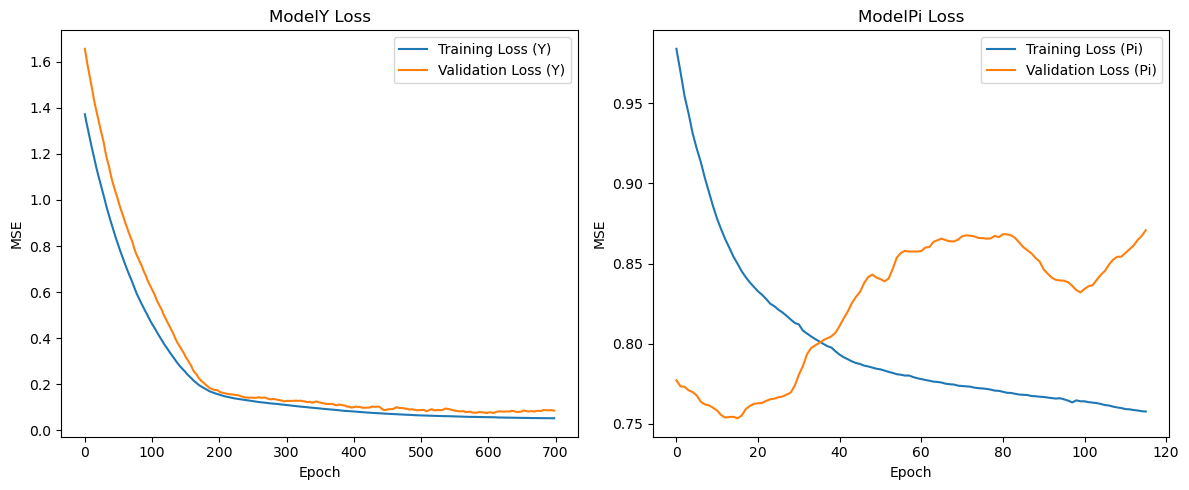

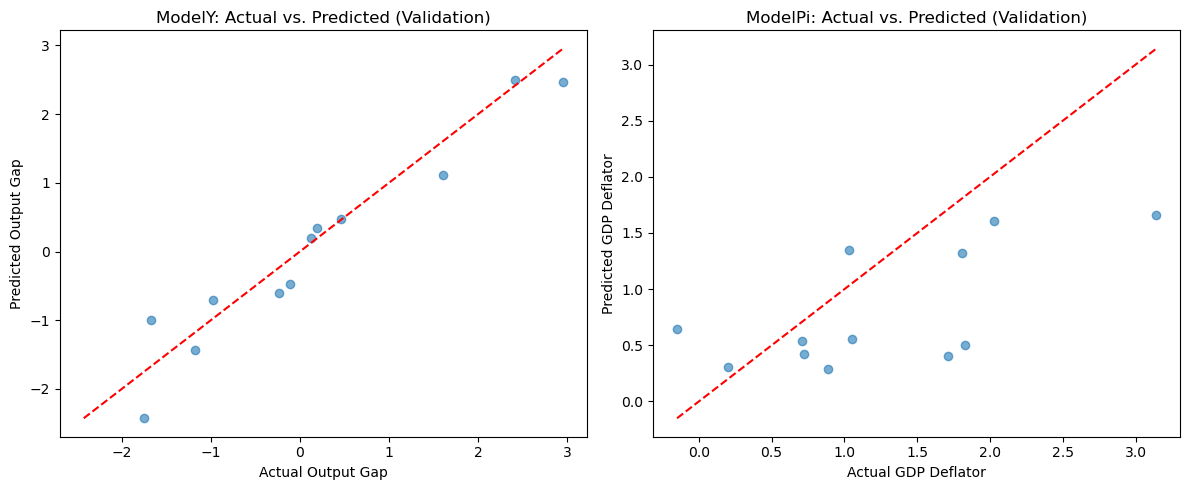


=== Sample Predictions ===
Y model predictions: [-0.6043626   2.4740553  -0.47995418 -2.4265025  -1.4300524 ]
Y actual values:     [-0.23  2.95 -0.11 -1.75 -1.18]
Pi model predictions: [0.5012137  1.3487791  0.42299968 1.3182545  1.6589812 ]
Pi actual values:     [1.83 1.03 0.72 1.81 3.14]


In [89]:
# 4.5 Plot training and validation losses
plt.figure(figsize=(12, 5))

# -- ModelY Loss
plt.subplot(1, 2, 1)
plt.plot(ann_model_y.train_losses, label='Training Loss (Y)')
plt.plot(ann_model_y.val_losses, label='Validation Loss (Y)')
plt.title('ModelY Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# -- ModelPi Loss
plt.subplot(1, 2, 2)
plt.plot(ann_model_pi.train_losses, label='Training Loss (Pi)')
plt.plot(ann_model_pi.val_losses, label='Validation Loss (Pi)')
plt.title('ModelPi Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# 4.6 Predictions (on validation set) - pass X_val unscaled
y_val_preds = ann_model_y.predict(X_y_val)
pi_val_preds = ann_model_pi.predict(X_pi_val)

# 4.7 Compare predictions to actual values
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Output Gap (ModelY) ---
ax[0].scatter(y_y_val, y_val_preds, alpha=0.6)
min_val = min(y_y_val.min(), y_val_preds.min())
max_val = max(y_y_val.max(), y_val_preds.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[0].set_title('ModelY: Actual vs. Predicted (Validation)')
ax[0].set_xlabel('Actual Output Gap')
ax[0].set_ylabel('Predicted Output Gap')

# --- Inflation (ModelPi) ---
ax[1].scatter(y_pi_val, pi_val_preds, alpha=0.6)
min_val = min(y_pi_val.min(), pi_val_preds.min())
max_val = max(y_pi_val.max(), pi_val_preds.max())
ax[1].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[1].set_title('ModelPi: Actual vs. Predicted (Validation)')
ax[1].set_xlabel('Actual GDP Deflator')
ax[1].set_ylabel('Predicted GDP Deflator')

plt.tight_layout()
plt.show()

# 4.8 Print some example predictions (unscaled input -> unscaled output)
print("\n=== Sample Predictions ===")
print("Y model predictions:", y_val_preds[:5])
print("Y actual values:    ", y_y_val[:5])

print("Pi model predictions:", pi_val_preds[:5])
print("Pi actual values:    ", y_pi_val[:5])